# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
bikes_df_raw = pd.DataFrame.from_csv("data/BSS_hour_raw.csv", index_col=None)
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


**Season:** Everything looks normal and makes sense.
**Hour:** Everything looks normal and makes sense.
**Holiday:** Everything looks normal and makes sense.
**Weekday:** Everything looks normal and makes sense.
**Working day:** Unexpected column, but I'm assuming 0 is false and 1 is true.
**Weather:** Everything looks normal and makes sense.
**Temp:** The normalized values seem reasonable.
**Apparent temp:** Everything looks normal and makes sense.
**Humidity:** Everything looks normal and makes sense.
**Windspeed:** Everything looks normal and makes sense.
**Casual:** The standard deviation is super high. I'm wondering about days with zero reported rides.
**Registered:** The standard deviation is super high. I'm wondering about days with zero reported rides.

**1.2 Notice that the variable in column...**

In [4]:
datetime = pd.to_datetime(bikes_df_raw['dteday'])

**1.3 Create three new columns in the dataframe:...**

In [5]:
years = list(map(lambda x: 0 if x.year == 2011 else 1,datetime))
months = list(map(lambda x: x.month, datetime))

bikes_df_raw['year'] = years
bikes_df_raw['month'] = months
bikes_df_raw['counts'] = bikes_df_raw['registered'] + bikes_df_raw['casual']

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

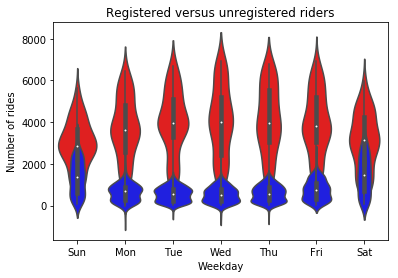

In [6]:
aggregation = {'weekday':'first',
              'weather':'max',
              'season':'first',
              'temp':'mean',
              'atemp':'mean',
              'windspeed':'mean',
              'hum':'mean',
              'casual':'sum',
              'registered':'sum',
              'counts':'sum'}

bikes_by_day = bikes_df_raw.groupby('dteday', as_index=False).agg(aggregation)
bikes_by_day.describe()

ax = sns.violinplot(x=bikes_by_day['weekday'], y=bikes_by_day['registered'], color="red")
ax = sns.violinplot(x=bikes_by_day['weekday'], y=bikes_by_day['casual'], color="blue")
ax.set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax.set_title("Registered versus unregistered riders")
ax.set_ylabel("Number of rides")
ax.set_xlabel("Weekday")
ax.legend()
plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

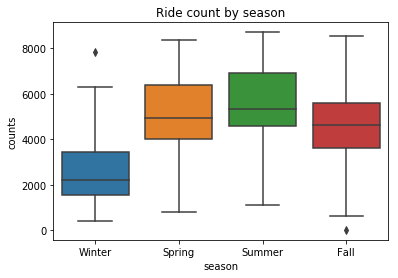

In [7]:
ax = sns.boxplot(x="season", y="counts", data=bikes_by_day)
ax.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax.set_title("Ride count by season")
plt.show()

The winter outlier is a day when St. Patrick's Day fell on a weekend, causing the number of rides to spike. The fall outlier is the day that Hurricane Sandy hit Washington, D.C., causing a plunge in ridership.

**2.3 Convert the categorical attributes...**

In [8]:
bikes_df = pd.get_dummies(bikes_df_raw, columns=['season','month','weekday','weather'])
bikes_df = bikes_df.join(bikes_df_raw[['season','month','weekday','weather']])

**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [9]:
bikes_train, bikes_test = train_test_split(bikes_df, 
                                           random_state=90, 
                                           train_size=.5, 
                                           test_size=.5,
                                           stratify=bikes_df['month'])

**2.5 Although we asked you to create your train and test set...**

In [10]:
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_train = BSS_train.drop(['dteday'], axis=1)

BSS_test = pd.read_csv('data/BSS_test.csv')
BSS_test = BSS_test.drop(['dteday'], axis=1)

**2.6 Use pandas' `scatter_matrix` command to visualize...**

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


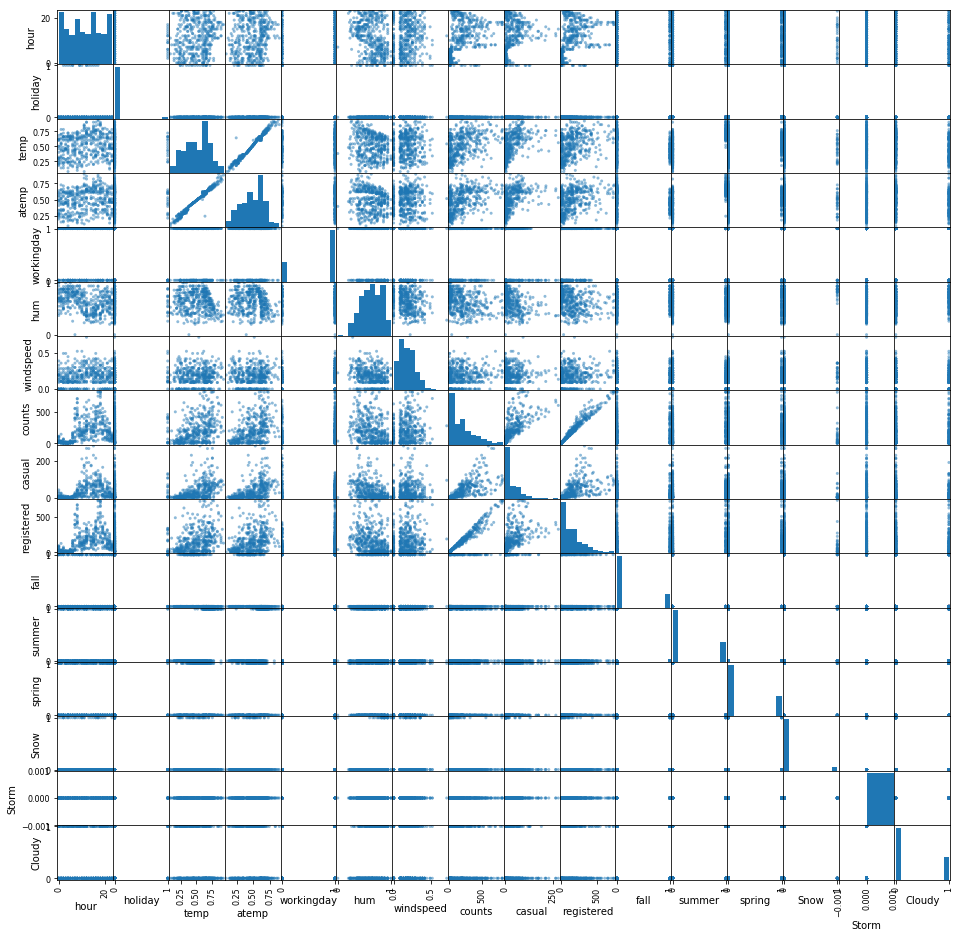

In [11]:
BSS_train_sample = BSS_train.sample(frac=.05)

scatter_matrix(BSS_train_sample[['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']], figsize=(16,16))

plt.show()

We can see several strongly-associated variables. The numeber of riders (count) seems to be strongly associated with both temperature and season. Registered riders affect the count much more than casual riders. We can also see a distribution throughout the day by hour. These trends can also be visualized with a heatmap:

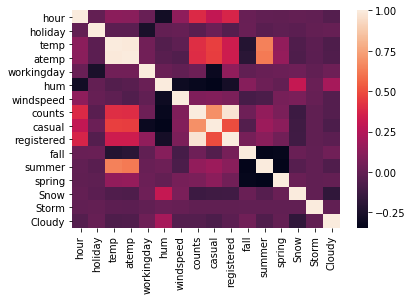

In [12]:
sns.heatmap(BSS_train[['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']].corr())
plt.show()

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

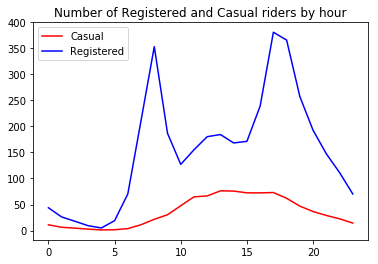

In [13]:
aggregation = {'casual':'mean',
            'registered':'mean'}

avg_riders = BSS_train.groupby('hour', as_index=False).agg(aggregation)
plt.plot(avg_riders['hour'], avg_riders['casual'], color='red', label='Casual')
plt.plot(avg_riders['hour'], avg_riders['registered'], color='blue', label='Registered')
plt.title("Number of Registered and Casual riders by hour")
plt.legend()
plt.show()

Registered riders have clear spikes during commuting hours, while casual riders tend to use the bikes during the middle of the day. Registered riders ride much more than casual riders.

**2.8 Use the weather related variables to show how each weather...** Use the one-hot-encoded weather related variables to show how each weather category affects the relationships in question 2.6. Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

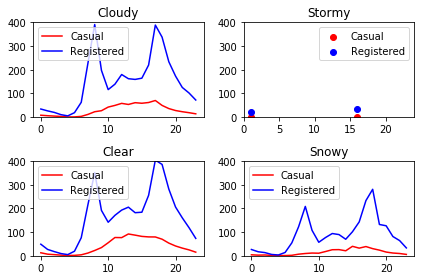

In [14]:
cloudy = BSS_train[BSS_train['Cloudy']==1].groupby('hour', as_index=False).agg(aggregation)
storm = BSS_train[BSS_train['Storm']==1].groupby('hour', as_index=False).agg(aggregation)
snow = BSS_train[BSS_train['Snow']==1].groupby('hour',as_index=False).agg(aggregation)
clear = BSS_train[(BSS_train['Cloudy']==0) & (BSS_train['Storm']==0) & (BSS_train['Snow']==0)].groupby('hour', as_index=False).agg(aggregation)

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(cloudy['hour'], cloudy['casual'], color='red', label='Casual')
axs[0, 0].plot(cloudy['hour'], cloudy['registered'], color='blue', label='Registered')
axs[0, 0].set_ylim([0, 400])
axs[0, 0].legend()
axs[0, 0].set_title("Cloudy")

axs[0, 1].scatter(storm['hour'], storm['casual'], color='red', label='Casual')
axs[0, 1].scatter(storm['hour'], storm['registered'], color='blue', label='Registered')
axs[0, 1].set_xlim([0, 24])
axs[0, 1].set_ylim([0, 400])
axs[0, 1].legend()
axs[0, 1].set_title("Stormy")

axs[1, 1].plot(snow['hour'], snow['casual'], color='red', label='Casual')
axs[1, 1].plot(snow['hour'], snow['registered'], color='blue', label='Registered')
axs[1, 1].set_ylim([0, 400])
axs[1, 1].legend()
axs[1, 1].set_title("Snowy")

axs[1, 0].plot(clear['hour'], clear['casual'], color='red', label='Casual')
axs[1, 0].plot(clear['hour'], clear['registered'], color='blue', label='Registered')
axs[1, 0].set_ylim([0, 400])
axs[1, 0].legend()
axs[1, 0].set_title("Clear")

plt.tight_layout()
plt.show()

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [15]:
X_train = BSS_train.drop(['casual','registered','counts'], axis=1)
X_train = sm.add_constant(X_train)

X_test = BSS_test.drop(['casual','registered','counts'], axis=1)
X_test = sm.add_constant(X_test)

Y_train = BSS_train['counts']
Y_test = BSS_test['counts']

results = sm.OLS(Y_train, X_train).fit()

print("\nR^2 score for training data: ", r2_score(Y_train, results.predict(X_train)))
print("R^2 score for test data: ", r2_score(Y_test, results.predict(X_test)))


R^2 score for training data:  0.411569982263
R^2 score for test data:  0.400721092294


**3.2 Examine the estimated coefficients and report...**

Here are the parameters that are statistically significant at a significance level of 5% (p-value < 0.05): 

In [16]:
results.pvalues[results.pvalues < .05]

const          5.319401e-03
hour          6.967036e-200
holiday        2.214061e-02
year          3.862196e-142
workingday     1.828978e-03
temp           9.243128e-06
atemp          1.229662e-02
hum            5.926590e-90
spring         1.510519e-07
summer         4.168321e-02
fall           6.554799e-14
Apr            3.897799e-04
May            2.023805e-04
Jun            1.392848e-07
Jul            3.606677e-09
Aug            1.084419e-04
Nov            6.623427e-03
Dec            4.454012e-02
Sat            2.255964e-02
Snow           1.092443e-05
dtype: float64

**3.3 You should see some strange estimates for the predictors representing months...** 

The July coefficient is the most extreme negative coefficient in the model. This implies that July has the strongest negative effect on counts of all the months. Humidity is also strongly negative, and I believe that we're seeing a weird value because humidity and summer months are colinear, which is making it impossible for us to have independent variables and to create a good model.

**3.4 To diagnose the model, make two plots:...**

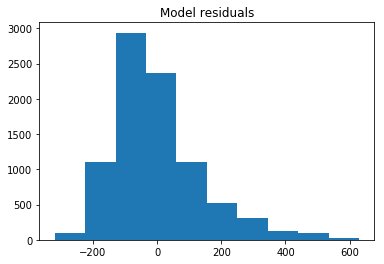

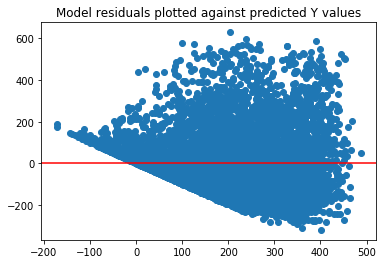

In [17]:
plt.hist(results.resid)
plt.title("Model residuals")
plt.show()

plt.scatter(results.predict(X_train), results.resid)
plt.axhline(y=0, color='red')
plt.title("Model residuals plotted against predicted Y values")
plt.show()

The residuals aren't normally distributed, which suggests that a linear regression isn't the best model for this data. The slope in the scatter plot suggests that we don't have constant variance. My hypothesis is that this stems from the fact that the days aren't independent. This model has a lot of colinearity too (i.e. seasons are correlated with weather and months), and an OLS model assumes no colinearity.

**3.5 Perhaps we can do better via a model...**

In [18]:
polynomial_features= PolynomialFeatures(degree=2)

X_train_poly = sm.add_constant(pd.concat([pd.DataFrame(polynomial_features.fit_transform(X_train[["temp","hour","hum"]]), 
                                       columns=['1','temp','hour','hum',
                                                'temp*temp','hour*hour','hum*hum',
                                                'temp*hour','hour*hum','hum*temp']),
                               X_train.drop(["temp","hour","hum"], axis=1)],
                              axis=1))

sm.OLS(Y_train, X_train_poly).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     272.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:42:57   Log-Likelihood:                -54223.
No. Observations:                8689   AIC:                         1.085e+05
Df Residuals:                    8652   BIC:                         1.088e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1           -152.2347     13.315    -11.434      0.000    -178.335    -126.135
temp         294.1199     87.809      3.350      0.001     121.994     466.246
hour          38.1334      1.240     30.764      0.000      35.704      40.563
hum          370.3622     57.157      6.480      0.000     258.321     482.403
temp*temp   -207.4426     49.690     -4.175      0.000    -304.847    -110.038
hour*hour     20.2029      1.149     17.576      0.000      17.950      22.456
hum*hum     -219.3549     44.443     -4.936      0.000    -306.475    -132.235
temp*hour     -1.4206      0.033    -42.428      0.000      -1.486      -1.355
hour*hum      -9.9333      1.200     -8.275      0.000     -12.286      -7.580
hum*temp    -210.9484     37.400     -5.640      0.000    -284.262    -137.635
const       -152.2347     13.315    -11.434      0.000    -178.335    -126.135
holiday       -9.8638      7.479     -1.319      0.187     -24.524       4.796
year          80.5220      2.719     29.616      0.000      75.192      85.852
workingday    11.1130      3.139      3.540      0.000       4.960      17.266
atemp         84.7455     59.818      1.417      0.157     -32.513     202.004
windspeed    -16.3227     12.267     -1.331      0.183     -40.369       7.724
spring        48.5990      8.509      5.712      0.000      31.920      65.278
summer        29.2274      9.962      2.934      0.003       9.700      48.755
fall          72.5101      8.439      8.593      0.000      55.968      89.052
Feb          -10.4519      6.893     -1.516      0.130     -23.965       3.061
Mar           -4.7245      7.756     -0.609      0.542     -19.927      10.478
Apr          -30.6839     11.550     -2.657      0.008     -53.326      -8.042
May          -25.1632     12.206     -2.062      0.039     -49.090      -1.237
Jun          -29.3425     12.339     -2.378      0.017     -53.530      -5.155
Jul          -36.6988     13.846     -2.650      0.008     -63.840      -9.557
Aug          -16.5032     13.593     -1.214      0.225     -43.148      10.141
Sept           8.9385     12.248      0.730      0.466     -15.071      32.947
Oct          -13.9537     11.425     -1.221      0.222     -36.350       8.443
Nov          -40.7560     10.984     -3.710      0.000     -62.287     -19.225
Dec          -29.5005      8.709     -3.387      0.001     -46.572     -12.429
Mon           -1.7848      3.353     -0.532      0.595      -8.357       4.788
Tue            1.4822      3.664      0.405      0.686      -5.700       8.664
Wed           -1.3189      3.643     -0.362      0.717      -8.460       5.822
Thu           -1.1496      3.584     -0.321      0.748      -8.175       5.876
Fri            4.0204      3.587      1.121      0.262      -3.012      11.052
Sat           17.0575      4.995      3.415      0.001       7.267      26.848
Cl

This model does seem to fit better, because the $r^2$ is better. These three variables are important, since all of their p-values are very small. 

Temp * hour has the highest t-score, showing that it has the most predictive value. That makes sense, because these two variables together take into account both the time of day and the seasonality of ridership (since temperatures vary with the season). 

Humidity * temp has more predictive value than either variable alone, which makes sense: humidity makes riding in hot weather way worse.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [19]:
X_train_drop = X_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

sm.OLS(Y_train, X_train_drop).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:42:57   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients are more sensible in this model. The July coefficient, for example, is much less skewed. The reason that dropping those columns helped is that 'workingday' is colinear with the days of the week, 'atemp' is colinear with 'temp' and 'hum', and the seasons are colinear with the months. Having multiple variables that are essentially describing the same thing violated the assumpions of a multivariable linear regression.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [20]:
BSS_train = BSS_train.drop(['workingday','atemp','spring','summer','fall'],axis=1)
BSS_test = BSS_test.drop(['workingday','atemp','spring','summer','fall'],axis=1)

**4.2 Write a function to standardize...**

In [21]:
def standardize(data, training_data, cols_to_standardize):
    data = data.copy()
    cols = data.columns.copy()
    for col in cols:
        if col in cols_to_standardize:
            data[col] = data[col].apply(lambda x: (x - training_data[col].mean())/training_data[col].std())
    return data

cols_to_standardize = X_train[X_train.columns.difference(['holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm','const'])].columns

practice_X_train_scaled = standardize(X_train, X_train, cols_to_standardize)
practice_X_train_scaled.describe()

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8689.0,8.689000e+03,8689.000000,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,1.0,7.326526e-17,0.029347,1.077015e-15,0.683048,1.180187e-14,9.509829e-15,3.874411e-14,7.452489e-14,0.250316,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,0.0,1.000000e+00,0.168788,1.000000e+00,0.465316,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.433220,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,1.0,-1.666263e+00,0.000000,-1.006755e+00,0.000000,-2.474050e+00,-2.764070e+00,-3.251787e+00,-1.546547e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,-8.042200e-01,0.000000,-1.006755e+00,0.000000,-8.122357e-01,-8.261956e-01,-7.554373e-01,-6.986934e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,5.782341e-02,0.000000,9.931755e-01,1.000000,1.867126e-02,5.465654e-02,-2.733539e-02,2.745877e-02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,9.198668e-01,0.000000,9.931755e-01,1.000000,8.495782e-01,8.477141e-01,8.047811e-01,5.118307e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.0,1.638236e+00,1.000000,9.931755e-01,1.000000,2.511392e+00,2.961759e+00,1.948941e+00,5.355550e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [22]:
def make_poly(data, poly_cols, degree):
    data = data.copy()
    cols = data.columns.copy()
    for col in cols:
        if col in poly_cols:
            for i in range(2, degree+1):
                data['{}^{}'.format(col, i)] = data[col]**i
    return data

poly_cols = practice_X_train_scaled[['temp', 'hum', 'windspeed', 'hour']]

practice_X_train_poly = make_poly(practice_X_train_scaled, poly_cols, 3)

print(practice_X_train_poly.columns)
practice_X_train_poly.head()

Index(['const', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'hour^2',
       'hour^3', 'temp^2', 'temp^3', 'hum^2', 'hum^3', 'windspeed^2',
       'windspeed^3'],
      dtype='object')


,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Snow,Storm,hour^2,hour^3,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3
0,1.0,1.350889,0,0.993176,1,-1.331553,-1.442501,-0.131350,0.511831,0,...,0,0,1.824900,2.465236,1.773032,-2.360885,0.017253,-0.002266,0.261971,0.134085
1,1.0,0.776193,0,-1.006755,1,0.641851,0.583749,1.064817,0.511831,0,...,1,0,0.602475,0.467637,0.411973,0.264426,1.133836,1.207329,0.261971,0.134085
2,1.0,-0.373198,0,0.993176,1,1.368895,1.464601,0.180694,-0.214322,0,...,0,0,0.139277,-0.051978,1.873874,2.565136,0.032650,0.005900,0.045934,-0.009845
3,1.0,0.776193,0,0.993176,0,0.641851,0.759920,-2.107627,0.875312,1,...,0,0,0.602475,0.467637,0.411973,0.264426,4.442090,-9.362266,0.766172,0.670640
4,1.0,-0.516872,0,0.993176,0,-1.643143,-1.618672,-1.171496,-0.456913,0,...,0,0,0.267157,-0.138086,2.699918,-4.436350,1.372402,-1.607762,0.208770,-0.095390


**4.4 Write code to add interaction terms to the model...**

In [23]:
def add_interaction_terms(data, poly_cols, month_days):
    data = data.copy()
    poly_cols = poly_cols.copy()

    for col in month_days:
        for poly_col in poly_cols:
            data['{}*{}'.format(col, poly_col)] = data[poly_col]*data[col]
    return data

poly_cols = practice_X_train_scaled[['temp', 'hum', 'windspeed']]
month_days = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
             'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

practice_X_train_poly = add_interaction_terms(practice_X_train_poly, poly_cols.columns, month_days).head()
practice_X_train_poly.head()

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Wed*windspeed,Thu*temp,Thu*hum,Thu*windspeed,Fri*temp,Fri*hum,Fri*windspeed,Sat*temp,Sat*hum,Sat*windspeed
0,1.0,1.350889,0,0.993176,1,-1.331553,-1.442501,-0.131350,0.511831,0,...,0.0,-1.331553,-0.131350,0.511831,-0.0,-0.0,0.0,-0.0,-0.0,0.0
1,1.0,0.776193,0,-1.006755,1,0.641851,0.583749,1.064817,0.511831,0,...,0.0,0.641851,1.064817,0.511831,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.373198,0,0.993176,1,1.368895,1.464601,0.180694,-0.214322,0,...,-0.0,1.368895,0.180694,-0.214322,0.0,0.0,-0.0,0.0,0.0,-0.0
3,1.0,0.776193,0,0.993176,0,0.641851,0.759920,-2.107627,0.875312,1,...,0.0,0.000000,-0.000000,0.000000,0.0,-0.0,0.0,0.0,-0.0,0.0
4,1.0,-0.516872,0,0.993176,0,-1.643143,-1.618672,-1.171496,-0.456913,0,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [39]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered','casual']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    month_days = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
             'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    
    cols_to_scale = ['temp', 'hum','windspeed', 'hour', 'counts']
    
    # create training dataset
    x_train = standardize(train_df, train_df, cols_to_scale)
    if (degree != 1):
        x_train = add_interaction_terms(x_train, columns_forpoly, month_days)
        x_train = make_poly(x_train, columns_forpoly, degree)

    y_train = pd.DataFrame(x_train[target_col])
    x_train = x_train.drop(bad_columns, axis=1)

    # create test dataset
    x_val = standardize(val_df, train_df, cols_to_scale)
    if (degree != 1):
        x_val = add_interaction_terms(x_val, columns_forpoly, month_days)
        x_val = make_poly(x_val, columns_forpoly, degree)
    
    y_val = pd.DataFrame(x_val[target_col])
    x_val = x_val.drop(bad_columns, axis=1)
    
    return x_train, y_train, x_val, y_val

**4.6 For each degree in 1 through 8...**

In [25]:
for i in range (1, 9):
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train, BSS_test, i)  
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    print("Degree ", i, ": ", reg.score(x_val, y_val))

Degree  1 :  0.434916923961
Degree  2 :  0.522519048729
Degree  3 :  0.572487917455
Degree  4 :  0.575181487349
Degree  5 :  0.586924051315
Degree  6 :  0.609356553104
Degree  7 :  0.644277783114
Degree  8 :  0.653891552383


**4.7 Discuss patterns you see in the results...**

The $r^2$ values are getting larger, suggesting that the model is getting better the higher degree we have. I'm somewhat suspicious of the monotonic increase, because I would have expected to see more overfitting. I suspect that something went wrong, and that's why my $r^2$ scores are wrong. At a certain point, a higher degree should work great for the training data but terribly for the test data.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [26]:
alphas = [.01,.05,.1,.5,1,5,10,50,100]
degrees = [1,2,3,4,5,6,7,8]
rows = []

train, test = train_test_split(BSS_train.loc[:], test_size=0.2, random_state=42)

for alpha in alphas:
    for degree in degrees:
        X_train, y_train, X_test, y_test = get_design_mats(train, test, degree)
        ridge_model = Ridge(alpha=alpha).fit(X_train, y_train)
        rows.append([degree, alpha, ridge_model.score(X_test,y_test)])
        
df = pd.DataFrame(rows, columns=['degrees','alphas','R2 scores'])

**5.2 Find the best-scoring degree and regularization combination.**

In [27]:
df.loc[df['R2 scores'].idxmax()]

degrees      8.000000
alphas       1.000000
R2 scores    0.658665
Name: 39, dtype: float64

**5.3 It's time to see how well our selected model...**

In [28]:
# Rebuild most successful model w/ most successful alpha and degree
X_train, y_train, X_test, y_test = get_design_mats(train, test, 8)
ridge_model = Ridge(alpha=1).fit(X_train, y_train)

# Get design matrices for BSS_test
X_train, y_train, X_test, y_test = get_design_mats(BSS_test, BSS_test, 8)
print("R2 score with best model using BSS_test: ", ridge_model.score(X_test,y_test))

R2 score with best model using BSS_test:  0.65085936574


This $r^2$ score is .6508, which is roughly the same as the score that made us pick the model (.6586). This suggests that the test data is more or less the same as the training data we used to build the model.

**5.4 Build a dataset with polynomial degree 1...**

In [53]:
alphas = [.1,.5,1,5,10,50,100]
X_train, y_train, X_test, y_test = get_design_mats(BSS_train, BSS_test, 1)

ols_model = LinearRegression().fit(X_train, y_train)
fitted_ridge = RidgeCV(alphas=alphas).fit(X_train, y_train)
fitted_lasso = LassoCV(alphas=alphas, max_iter=1e6).fit(X_train, y_train)

print('R^2 score for OLS model: ', ols_model.score(X_test, y_test))

ridge_a = fitted_ridge.alpha_
print('\nBest alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(X_test,y_test)))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {}'.format(lasso_a, fitted_lasso.score(X_test,y_test)))

R^2 score for OLS model:  0.397194782585

Best alpha for ridge: 10.0
R^2 score for Ridge with alpha=10.0: 0.39722587579574686

Best alpha for lasso: 0.1
R squared score for Lasso with alpha=0.1: 0.3128969701913489


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**5.5 Plot histograms of the coefficients found...** 

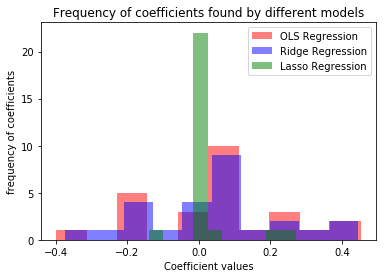

In [59]:
plt.hist(ols_model.coef_[0], color = 'red', label = 'OLS Regression', alpha = 0.5)
plt.hist(fitted_ridge.coef_[0], color = 'blue', label = 'Ridge Regression', alpha = 0.5)
plt.hist(fitted_lasso.coef_, color = 'green', label = 'Lasso Regression', alpha = 0.5)
plt.xlabel('Coefficient values')
plt.ylabel('frequency of coefficients')
plt.title('Frequency of coefficients found by different models')
plt.legend()

plt.show()

The coefficients are centered around zero, with only a few coefficients with larger magnitudes. Most are fairly low, which makes sense given the reduced coefficients we see with lasso and ridge penalty terms.

**5.6 The plots above show the overall distribution of... ** coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

Hint: Bar plots are a possible choice, but you are not required to use them

Hint: use xticks to label coefficients with their feature names

In [33]:
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(fitted_ridge.coef_))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, fitted_ridge.coef_, color='#7f6d5f', width=barWidth, edgecolor='white', label='Ridge')
plt.bar(r2, fitted_lasso.coef_, color='#557f2d', width=barWidth, edgecolor='white', label='Lasso')
plt.bar(r3, ols_model, color='#2d7f5e', width=barWidth, edgecolor='white', label='OLS')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], X_test.columns)
 
# Create legend & Show graphic
plt.legend()
plt.show()


TypeError: only length-1 arrays can be converted to Python scalars

**5.7 What trends do you see...** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*